# Bibliotecas

In [1]:
import Pkg; 
#Pkg.precompile()
#Pkg.add("RecipesBase");
#Pkg.add("Shapefile");
#Pkg.add("GeometricalPredicates")
#Pkg.add("GeoInterface")
#Pkg.add("GeometryBasics")
#Pkg.add("GeoDataFrames")
#Pkg.add("ArchGDAL")
#Pkg.add("PolygonOps")
#Pkg.add("StaticArrays")
#Pkg.add("CSV")

In [2]:
using RecipesBase
using Shapefile
using GeoInterface
using PolygonOps
using StaticArrays
using GeoDataFrames; const GDF=GeoDataFrames
using DataFrames
using CSV
using ColorSchemes
using ArchGDAL

using Distributions, Statistics
using Clustering
using Plots, GeometryBasics, VoronoiCells
using StatsBase

using Random

default(size=(800,600))

# Funciones

In [3]:
function bounding_box(shapes) #::Vector{Union{Missing, Shapefile.Polygon}}) #::Vector{Shapefile.Polygon})
    xmin, ymin = Inf, Inf
    xmax, ymax = -Inf, -Inf

    for shape in shapes
        p = GeoInterface.bbox(shape)
        xmin = min(xmin, p.X[1])
        ymin = min(ymin, p.Y[1])
        xmax = max(xmax, p.X[2])
        ymax = max(ymax, p.Y[2])
    end

    return (xmin, ymin, xmax, ymax)
end

bounding_box (generic function with 1 method)

In [4]:
function rbf(x; weights=[1], centers=[0,0], sigma2=[1])
    
    @assert length(weights)==size(centers)[1]==length(sigma2)>0 #chequeo consistencia de n>0
    K=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x[1])
    
    kernels = [exp(-sum((x-centers[j]).^2)/(2*sigma2[j])) for j=1:K]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

In [5]:
function sample_rbf(N,rbf_func,xlims,ylims,cota=2.0)
    
    v=Vector{Point2}(undef,N)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = Point2(u1,u2)
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

In [6]:
function integrate_voronoi(f, total_area, total_points)
    return total_area/total_points*sum(f)
end

function g(x;w,mu,sigma2)
   return rbf(x, weights=w, centers=mu, sigma2=sigma2)
end

function h(x;w,mu,sigma2)
    return 1
end

function g_j(x;j,w,mu,sigma2)
   return rbf(x, weights=[w[j]], centers=[mu[j]], sigma2=[sigma2[j]])
end

function h0_j(x;j,w,mu,sigma2)
    return 1/w[j]
end

function h1_j(x;j,w,mu,sigma2)
    return sum((x-mu[j]).^2)/(sigma2[j]^2)
end

function h2_j(x;j,w,mu,sigma2)
    return 2/sigma2[j]*(x-mu[j])
end

h2_j (generic function with 1 method)

In [7]:
function calculate_w(v_i, y, mu, sigma2, A_X, P)
    
    s = length(y)
    K = length(mu)
    
    # Calculate A matrix
    A = zeros(s,K)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:K
            g_j_aux = g_j.(v, j=j, w=ones(K), mu=mu, sigma2=sigma2)
            A[i,j] =  integrate_voronoi(g_j_aux, A_X, P)
        end
    end
    
    # Least square min||Aw-y||
    w = (A \ y)
end

calculate_w (generic function with 1 method)

In [8]:
function integrate(v_i, theta, error_i)
    
    w = theta[1]
    mu = theta[2]
    sigma2 = theta[3]
    
    K = length(w)
    s = length(error_i)
    
    # ========== Compute Loss differentials aproximations ========== 
    n0 = zeros(s,K)
    n1 = zeros(s,K)
    n2x1 = zeros(s,K)
    n2x2 = zeros(s,K)

    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:K
            
            g_j_out  = g_j.(v, j=j, w=w, mu=mu, sigma2=sigma2) # Calculate only kernel j (RBF)
            
            # Para w_j (ahora por minimos cuadrados)
#            h0_j_out = h0_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
#            n0[i,j] = (integrate_voronoi(g_j_out.*h0_j_out, A_X, P))
            
            # Para sigma2_j
            h1_j_out = h1_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            n1[i,j] = (integrate_voronoi(g_j_out.*h1_j_out, A_X, P))
            
            # Para mu_j (se separa por cada dimension)
            h2_j_out = h2_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            n2x1[i,j] = (integrate_voronoi(g_j_out.*[h2_j_out[l][1] for l = 1:length(h2_j_out)], A_X, P))
            n2x2[i,j] = (integrate_voronoi(g_j_out.*[h2_j_out[l][2] for l = 1:length(h2_j_out)], A_X, P))
        end
    end
    
    # ========== Make the sums ========== 
    dL_w = zeros(K)
    dL_sigma2 = zeros(K)
    dL_mux1 = zeros(K)
    dL_mux2 = zeros(K)

    for j = 1:K
#        dL_w[j] = sum(error_i.*n0[:,j])
        dL_sigma2[j] = sum(error_i.*n1[:,j])
        dL_mux1[j] = sum(error_i.*n2x1[:,j])
        dL_mux2[j] = sum(error_i.*n2x2[:,j])
    end

    dL_mu = [[dL_mux1[j], dL_mux2[j]] for j = 1:K] 

    dL = dL_w, dL_mu, dL_sigma2
    return dL
end

integrate (generic function with 1 method)

# Pre-procesamiento

In [9]:
# Importar y pre-procesar el dataframe de demand
demand_path = normpath(pwd() * "/data/demanda.csv")
demand = CSV.read(demand_path, DataFrame, header=2, limit=900) #Toma los primeros 900 datos, sin 2 filas (encabezado)
demand = demand[!,[1,22,23]] # Se queda con 2019 
rename!(demand,[:ZIP, :TotalGallons, :TotalStations])
conversion_factor = 3.78541*12 # liters/gallon * kms/liter
demand[!,:TotalKms] = demand[!,:TotalGallons] * conversion_factor; # En Kms

In [10]:
# Importar y pre-procesar el dataframe de zipcodes
cal_zip_path = normpath(pwd() * "/data/California_Zip_Codes/California_Zip_Codes.shp")
cal_zip_table = Shapefile.Table(cal_zip_path) # Levantar la información con las columnas 
cal_zip_shape = Shapefile.shapes(cal_zip_table); # Separar todos los poligonos que componen el Shapefile

cal_zip_df = GDF.read(cal_zip_path)
transform!(cal_zip_df, :ZIP_CODE => ByRow(x -> parse(Int64, x)) => :ZIP) #Se pasa el ZIP_CODE (string) a ZIP (Int64)
cal_zip_df[!,:shape] = cal_zip_shape; #Se le adjunta el shape de esa zona

In [11]:
# Unir los dataframes y qudarse con el condado de Los Ángeles
data = innerjoin(cal_zip_df, demand, on=:ZIP); # Agrega los datos de demand por los ZIP de cada zona
data = data[findall(x -> (x >= 90001 && x <= 90262) || (x >= 90266 && x <= 90703) || (x >= 90705 && x <= 90899),data.ZIP),:]; # Se queda con LA County (consecutivos)
data.TotalKms[ismissing.(data.TotalKms)] .= 0;
data.TotalGallons[ismissing.(data.TotalGallons)] .= 0;
data.TotalStations[ismissing.(data.TotalStations)] .= 0;
names(data);

In [12]:
# Obtener el rectángulo que contiene a la región
xmin, ymin, xmax, ymax = bounding_box(data.shape);

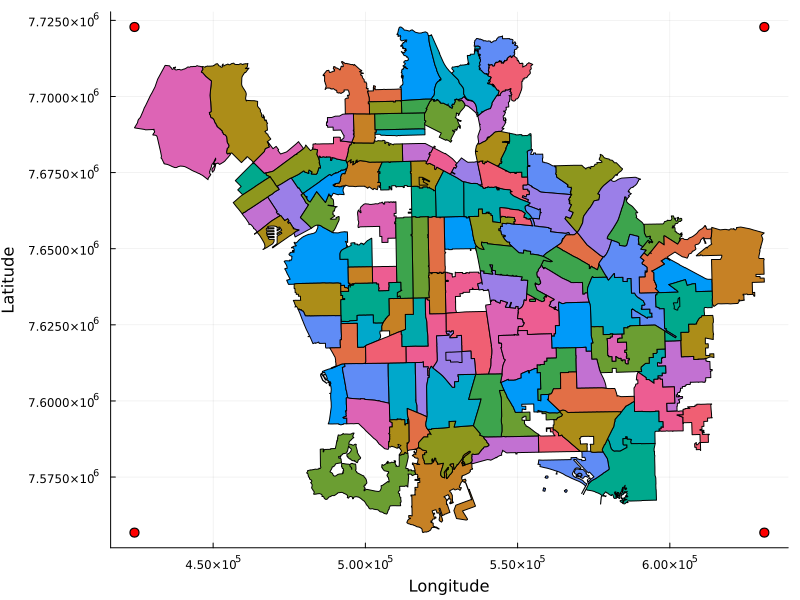

In [13]:
# Visualizar las zonas y el rectángulo
plot(data.shape)
scatter!(
    [xmin, xmax, xmax, xmin],
    [ymin, ymin, ymax, ymax],
    color = :red,
    markersize = 5,
    aspect_ratio = :equal,
    xlabel = "Longitude", ylabel = "Latitude",
    legend = false
)

In [37]:
plot(data.shape, fill_z=reshape(data.TotalKms, 1, nrow(data)))
savefig("real.pdf")

# Generación de puntos y asignación

In [15]:
# Generar 10,000 puntos aleatorios dentro del rectángulo que encierra el polígono de California
ancho = abs(xmax-xmin)
alto = abs(ymax-ymin)
total_area = ancho*alto

xmin_norm = 0;
xmax_norm = 1;
ymin_norm = 0;
ymax_norm = 1;
rho_x = (xmax_norm-xmin_norm)/(xmax-xmin); #scale
rho_y = (ymax_norm-ymin_norm)/(ymax-ymin); #scale

n_points = 10000

xp = rand(xmin:xmax, n_points)
yp = rand(ymin:ymax, n_points)
points = [SVector(xp[i], yp[i]) for i in 1:n_points];

In [16]:
# Asignar puntos a las diferentes Areas
areas = []
for shape in data.shape
    shape_points = [SVector(p.x, p.y) for p in shape.points]
    if (first(shape_points).x != last(shape_points).x && first(shape_points).y != last(shape_points).y)
        push!(shape_points,first(shape_points))
    end
    push!(areas, shape_points)
end

#areas = shuffle(areas)

s = length(areas)

attachments = []
attached_points = []
y = zeros(s)
attachments_per_zip = zeros(s)
x1_sum = zeros(s)
x2_sum = zeros(s)
v_i = [[] for i = 1:s]

for point in points
    area_idx = 0
    for area in areas
        area_idx+=1
        if inpolygon(point, area, HormannAgathos(); in=true, on=false, out=false) # Algoritmo alt.: HaoSun()
            push!(attachments, area_idx) #data.OBJECTID[area_idx])
            push!(attached_points, point)
            attachments_per_zip[area_idx] += 1 
            x1_sum[area_idx] += point[1] 
            x2_sum[area_idx] += point[2]
            push!(v_i[area_idx], )
            break
        end
    end
end

In [17]:
x1 = x1_sum./attachments_per_zip;
x2 = x2_sum./attachments_per_zip;

#normalizado
x1 = (x1.-xmin).*rho_x.+xmin_norm
x2 = (x2.-ymin).*rho_y.+ymin_norm

x = hcat(x1, x2)

attachments = Int64.(attachments);
xp = [attached_points[i][1] for i = 1:length(attached_points)] 
yp = [attached_points[i][2] for i = 1:length(attached_points)] 

#normalizado
xp = (xp.-xmin).*rho_x.+xmin_norm
yp = (yp.-ymin).*rho_y.+ymin_norm

ap = hcat(xp,yp)
v_i = [ ap[findall(x->x==i,attachments),:] for i in 1:s];

In [18]:
# Visualizar la asignación
#plot(data.shape, legend=false)
#scatter!(Tuple.(attached_points), marker_z=attachments, aspect_ratio = :equal)
#scatter!(x1, x2, markersize = 10)

### Calcular la RBF ###

### Inicialización ###

In [19]:
# THETA INITIALIZATION 

x1_rbf=(xmin_norm:abs(xmax_norm-xmin_norm)/200:xmax_norm);
x2_rbf=(ymin_norm:abs(ymax_norm-ymin_norm)/200:ymax_norm);
x_rbf=[[a, b] for b in x2_rbf, a in x1_rbf]; ##el orden de b y a importa no entendí por qué.

y = zeros(s) + (data.TotalKms./sum(data.TotalKms)) ## Revisar
K = 4
A_X = abs(xmax_norm-xmin_norm)*abs(ymax_norm-ymin_norm)
P = n_points
R = kmeans(x', K, weights = y, maxiter = 200, display=:iter);
println("========")
mu = [[R.centers'[j,1],R.centers'[j,2]] for j=1:K];
println("mu= ", mu)
mu1 = R.centers'[:,1];
mu2 = R.centers'[:,2];

sigma2 = [var(x[findall(x->x==j,assignments(R)),:]) for j in 1:K];
println("sigma2= ", sigma2)

w = calculate_w(v_i, y, mu, sigma2, A_X, P);
println("w= ", w)

theta0 = w, mu, sigma2;
theta = theta0;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.065027e-02
      1       2.270060e-02      -7.949667e-03 |        4
      2       2.196954e-02      -7.310569e-04 |        4
      3       2.157201e-02      -3.975332e-04 |        3
      4       2.153840e-02      -3.360887e-05 |        2
      5       2.152526e-02      -1.314060e-05 |        2
      6       2.148927e-02      -3.599183e-05 |        2
      7       2.147945e-02      -9.813271e-06 |        0
      8       2.147945e-02       0.000000e+00 |        0
K-means converged with 8 iterations (objv = 0.02147945442470831)
mu= [[0.5504860602410848, 0.722450208496205], [0.46986181028539303, 0.32061026710910356], [0.30896860954818794, 0.6549047536316506], [0.7836408111539002, 0.400321291619093]]
sigma2= [0.02075320641594403, 0.0176113263313119, 0.04420991093593973, 0.05265050500849479]
w= [1.2016074493586448, 1.54613669098607, 1.782069448154055, 2.080

In [20]:
z = rbf.(x_rbf, weights=theta[1],centers=theta[2],sigma2=theta[3]);

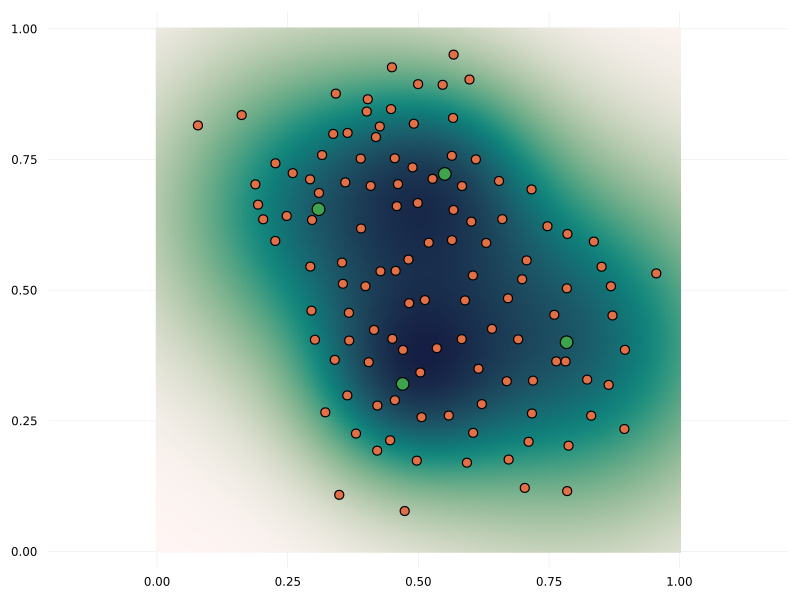

In [21]:
heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, colorbar=:none)#, lims=(min(xmin,ymin),max(xmax,ymax)), colorbar=:none)
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

mu_x = [mu[i][1] for i = 1:length(mu)]
mu_y = [mu[i][2] for i = 1:length(mu)]
scatter!(mu_x, mu_y, legend=:none, colorbar=:none, markersize = 7)

#annotate!([(x1[i] + 0.02, x2[i] + 0.03, text(i, :black)) for i in 1:s]) # Add Station Number
#plot!(tess, alpha=1, color=:green)

In [22]:
i = 1
v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3])
#hcat(integrates, y);

In [23]:
integrates = zeros(s)
for i=1:s
    v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
    g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3])
    integrates[i] = integrate_voronoi(g_out, A_X, P)
end
error_i = integrates - y
loss = 1/2*sum(error_i.^2);
minLoss = loss;
loss_vector = [loss]
theta_vector = [theta];

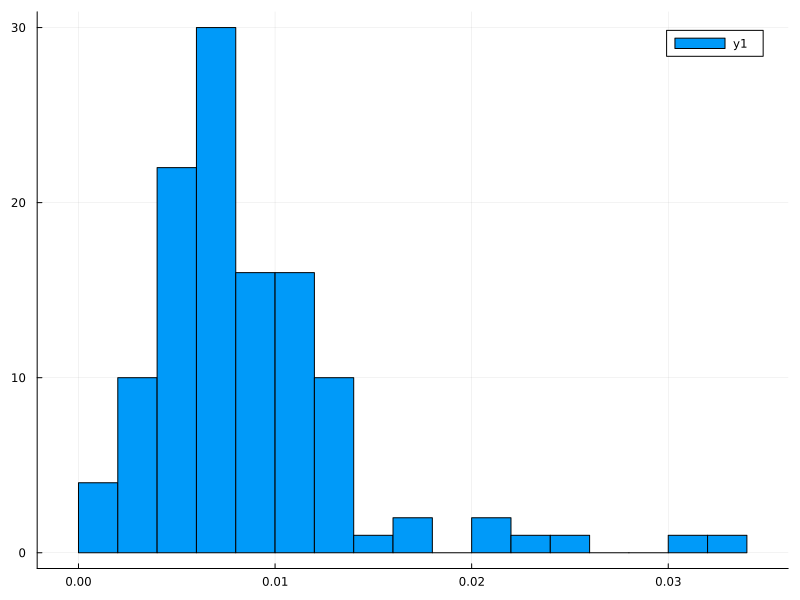

In [24]:
hist = fit(Histogram,y, nbins=25)
plot(hist)

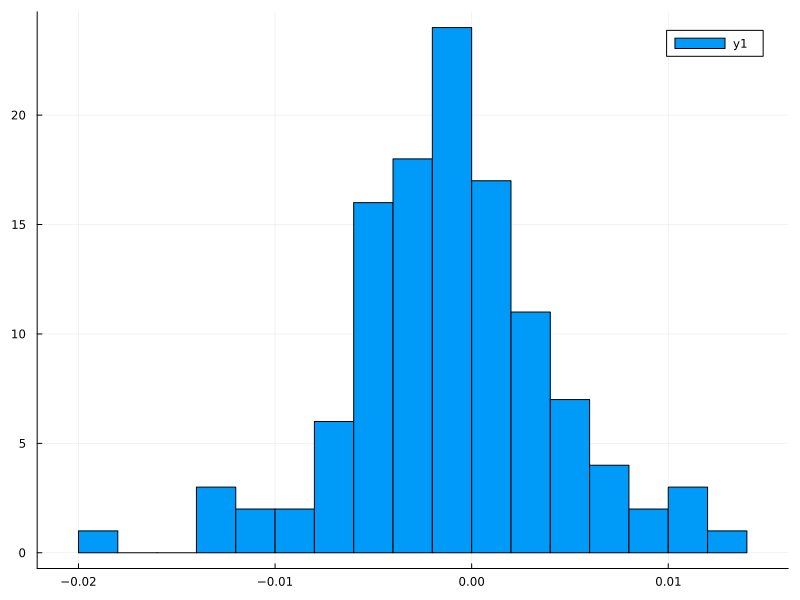

In [25]:
hist = fit(Histogram,error_i, nbins=25)
plot(hist)

Ideas:
- Tomar logaritmo de los datos (por el sesgo que tiene el error, a la izquierda) y trabajar con eso. Deshacer el cambio de variable para comparar contra este.
- Probar sin correr todo el algoritmo.

Validación leave one out:
- Probar ya con el k-means de primera (el ajuste no es malo)
- Sacar 1 zip y su "y" respectivo, utilizar el método. Se genera un ocnjunto de centros, varianzas que no dependen de ese. 
- por cada ajuste, tengo un set diferente.
- Calculo la predicción para el que dejé afuera y lo comparo. 
- Repetir para todos, da idea de la validez del método para interpolar.

Cuaderno:
- Limpiar un poco
- Dejar como antes

In [26]:
theta

([1.2016074493586448, 1.54613669098607, 1.782069448154055, 2.0804353859175406], [[0.5504860602410848, 0.722450208496205], [0.46986181028539303, 0.32061026710910356], [0.30896860954818794, 0.6549047536316506], [0.7836408111539002, 0.400321291619093]], [0.02075320641594403, 0.0176113263313119, 0.04420991093593973, 0.05265050500849479])

### Bucle ###

In [27]:
integration_max_steps = 2000
for k = 1:integration_max_steps
    #nu = max(nu*nu_decay, nu_min)
    nu = 0.1
    
    # ========== STEP ========== 
    oldTheta = theta;
    dL = integrate(v_i, theta, error_i);
#    println("theta: ", theta)
#    println("   dL: ",dL)
    theta = theta .- nu.*dL;
    w = calculate_w(v_i, y, theta[2], theta[3], A_X, P); # Calcular weights por minimos cuadrados
    theta = w, theta[2], theta[3]; # Fixme: no me dejó sobreescribir, tuve que armar los 3 datos
    push!(theta_vector, theta);
    # ===========================
    
    # ========== Check if mu is still inside the area ========== 
#    mux = [theta[2][i][1] for i = 1:length(theta[2])];
#    muy = [theta[2][i][2] for i = 1:length(theta[2])];
#    inside_x = minimum(mux) > xmin_norm && maximum(mux) <= xmax_norm;
#    inside_y = minimum(muy) > ymin_norm && maximum(muy) <= ymax_norm;
#    inside = inside_x && inside_y
#    if !inside
#        #println("Una de las RBF se salio del cuadrado, en ", k, " iteraciones.");
#        #break
#    end
    # ========================================================== 

    # ========== Recalculate ========== 
    integrates = zeros(s)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3]);
        integrates[i] = integrate_voronoi(g_out, A_X, P);
    end
    error_i = integrates - y;
    # =================================
    
    # ========== Comprobar descenso ==========
    oldLoss = loss
    loss = 1/2*sum(error_i.^2);
    push!(loss_vector, loss);
    if (length(loss_vector) > 50 && loss > oldLoss)
        println("cortar por umbral en ", k, " iteraciones")
        k = integration_max_steps
        break
    end
    # ========================================
end

In [28]:
theta = theta_vector[length(theta_vector)-1]

([2.138866588314308, 2.587197748257888, 2.7477454983083867, 2.3026425123774437], [[0.5284380363214418, 0.8336981122830626], [0.38363003358628833, 0.3860602850901956], [0.3136958907911833, 0.6921521638294609], [0.8413289756570044, 0.4436329593433]], [0.012994597189382187, 0.022637440715765563, 0.012017776744111204, 0.06761383438400824])

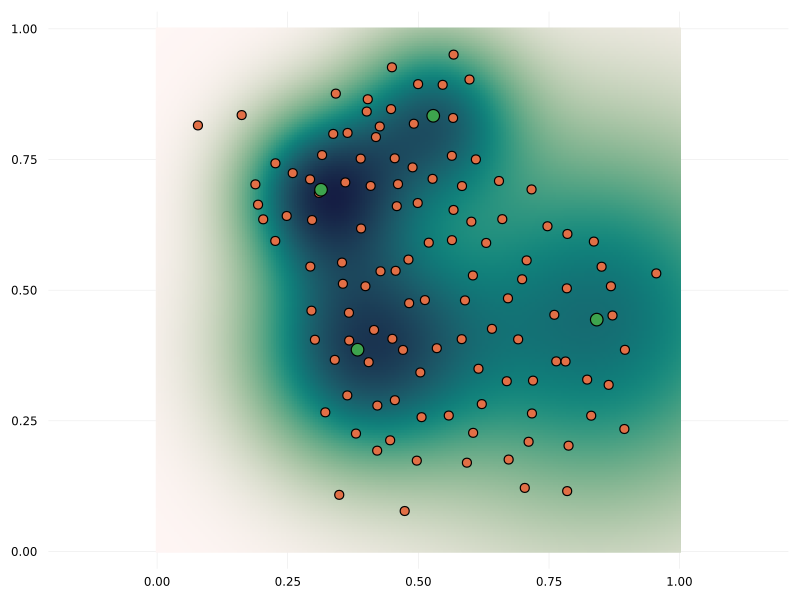

In [29]:
z = rbf.(x_rbf, weights=theta[1],centers=theta[2],sigma2=theta[3]);

heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off,colorbar=:none)#, lims=(min(X1_min,X2_min),max(X1_max,X2_max)))
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

mu_x = [theta[2][i][1] for i = 1:length(theta[2])]
mu_y = [theta[2][i][2] for i = 1:length(theta[2])]
scatter!(mu_x, mu_y, legend=:none, colorbar=:none, markersize = 7)

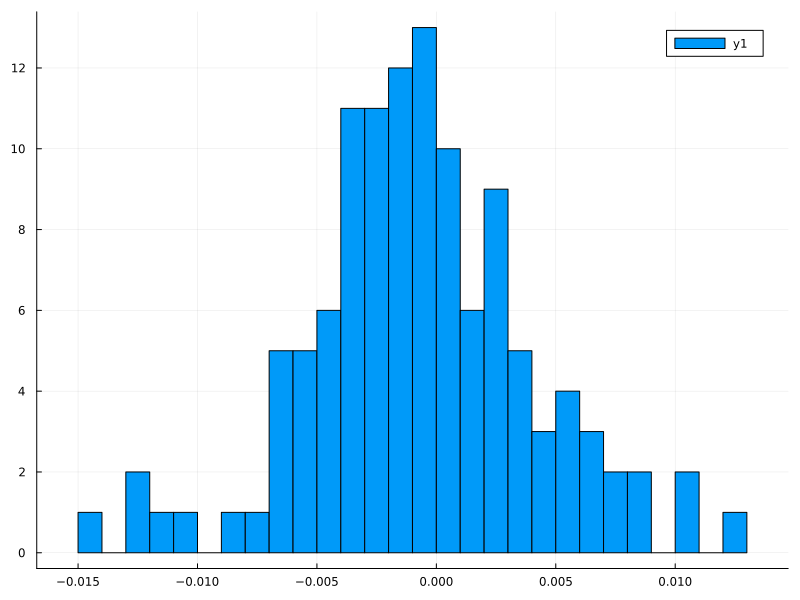

In [30]:
plot(fit(Histogram, error_i, nbins=25))

In [31]:
scatter(loss_vector)
savefig("loss.pdf")

In [31]:
theta

([3.152040134237798, 1.5419791934975986, 1.173181258442217, 6.182058046778211], [[0.3733742175479463, 0.7437317374562229], [0.7574781088980593, 0.5489988151757175], [0.6806250149783267, 0.2873911675795254], [0.3538461058588267, 0.48205537445334906]], [0.015994641006522987, 0.0691049823392998, 0.08284006396739176, 0.0020311320568288885])

In [32]:
theta0

([2.241142120957063, 1.3071345745522773, 1.6537104484132001, 2.0996514276195857], [[0.39249824000148575, 0.7540603536528911], [0.7448326247433593, 0.5476818386416058], [0.6891983979469056, 0.2814763084195759], [0.4018141236378725, 0.40558302243259015]], [0.0455084106426895, 0.017983725908201437, 0.05757755084014978, 0.009900425768582934])

In [32]:
hcat(y, integrates, integrates.-y)

117×3 Matrix{Float64}:
 0.00757465  0.00618882  -0.00138584
 0.013481    0.00729768  -0.00618332
 0.00734543  0.00743289   8.74617e-5
 0.00615951  0.0057489   -0.000410613
 0.0114296   0.00580718  -0.00562242
 0.0         0.0104385    0.0104385
 0.0070494   0.00488987  -0.00215954
 0.012271    0.00671076  -0.00556022
 0.00663536  0.00690135   0.000265993
 0.0128626   0.00903144  -0.00383118
 0.00349981  0.00270777  -0.000792033
 0.002303    0.00364653   0.00134353
 0.0133284   0.00680832  -0.00652005
 ⋮                       
 0.00509033  0.00859017   0.00349984
 0.010882    0.0137504    0.00286842
 0.00557584  0.0069981    0.00142227
 0.0032507   0.00534246   0.00209176
 0.00676427  0.00225694  -0.00450733
 0.0160191   0.0114214   -0.00459771
 0.00720391  0.00539426  -0.00180966
 0.00835893  0.00668677  -0.00167216
 0.0109214   0.0106842   -0.000237119
 0.00597346  0.00822453   0.00225107
 0.00642141  0.00393602  -0.00248538
 0.0126539   0.00976275  -0.00289113

In [33]:
hcat(y.*data.TotalKms, integrates.*data.TotalKms, integrates.-y)

117×3 Matrix{Float64}:
 4.29109e6  3.506e6    -0.00138584
 1.35921e7  7.35782e6  -0.00618332
 4.03531e6  4.08335e6   8.74617e-5
 2.83749e6  2.64833e6  -0.000410613
 9.77021e6  4.96407e6  -0.00562242
 0.0        0.0         0.0104385
 3.71661e6  2.57805e6  -0.00215954
 1.12616e7  6.15876e6  -0.00556022
 3.29284e6  3.42484e6   0.000265993
 1.23737e7  8.68817e6  -0.00383118
 9.16073e5  7.08759e5  -0.000792033
 3.96669e5  6.28079e5   0.00134353
 1.32861e7  6.78671e6  -0.00652005
 ⋮                     
 1.93791e6  3.27031e6   0.00349984
 8.85648e6  1.1191e7    0.00286842
 2.32521e6  2.91832e6   0.00142227
 7.90308e5  1.29885e6   0.00209176
 3.42203e6  1.14178e6  -0.00450733
 1.91918e7  1.36835e7  -0.00459771
 3.88131e6  2.90631e6  -0.00180966
 5.22568e6  4.18032e6  -0.00167216
 8.92062e6  8.72694e6  -0.000237119
 2.66866e6  3.67434e6   0.00225107
 3.08392e6  1.8903e6   -0.00248538
 1.19754e7  9.23927e6  -0.00289113

In [34]:
minimum(loss_vector)

0.0013393895087599119

In [35]:
loss_vector

305-element Vector{Float64}:
 0.0016952395893688379
 0.0016875508198228725
 0.0016799629203330204
 0.001672445940807615
 0.0016649765727095114
 0.0016575374094827333
 0.0016501165993505487
 0.0016427078006930078
 0.0016353103720003676
 0.0016279297341239886
 0.0016205778346844901
 0.0016132736242278696
 0.0016060434225645631
 ⋮
 0.0013407490392454771
 0.0013405862490001943
 0.00134042572359464
 0.0013402674119755188
 0.001340111265875321
 0.001339957248414033
 0.0013398053940300335
 0.0013396561333515681
 0.0013395122396256938
 0.0013393907873436464
 0.0013393895087599119
 0.0013401559319753892

In [36]:
w_vector = [theta_vector[l][1] for l=1:length(theta_vector)]
mu_vector = [theta_vector[l][2] for l=1:length(theta_vector)]
sigma2_vector = [theta_vector[l][3] for l=1:length(theta_vector)]
mux_vector = [[mu_vector[l][k][1] for k=1:K] for l=1:length(mu_vector)]
muy_vector = [[mu_vector[l][k][2] for k=1:K] for l=1:length(mu_vector)];

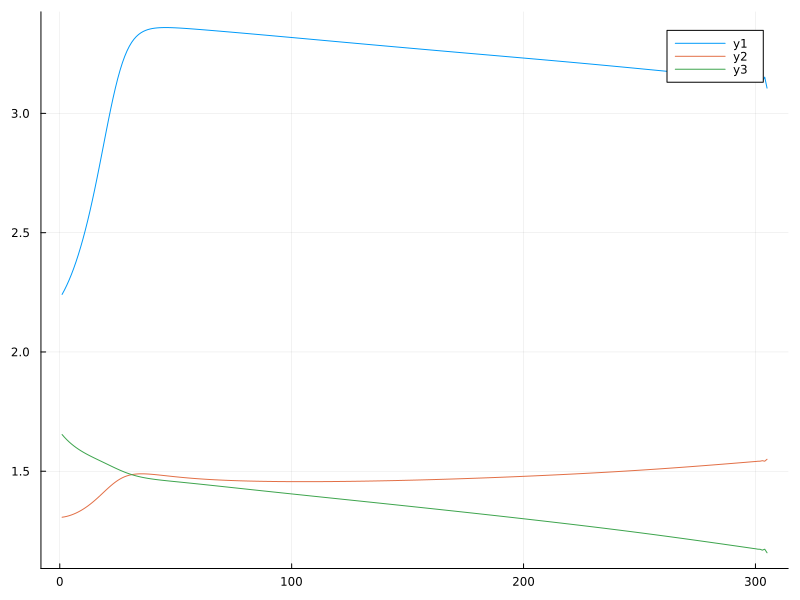

In [37]:
 plot([w_vector[l][1] for l=1:length(w_vector)])
plot!([w_vector[l][2] for l=1:length(w_vector)])
plot!([w_vector[l][3] for l=1:length(w_vector)])

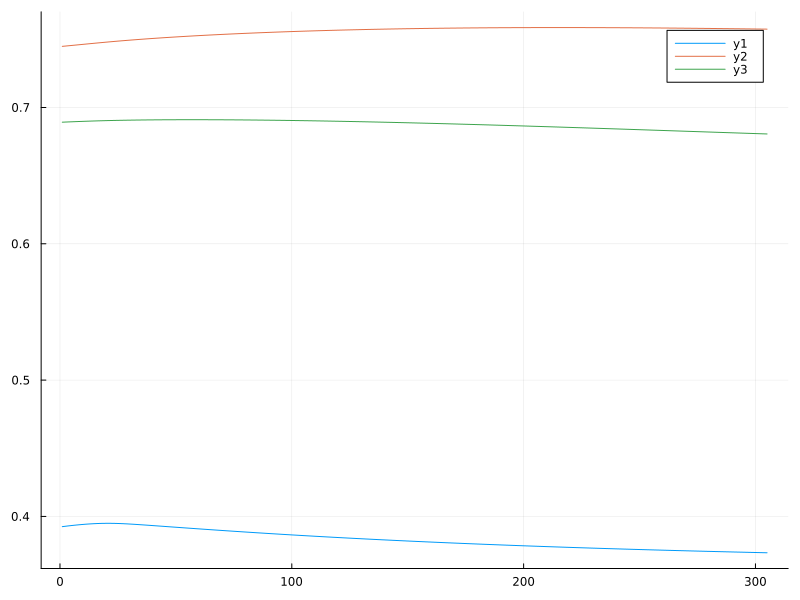

In [38]:
 plot([mux_vector[l][1] for l=1:length(mu_vector)])
plot!([mux_vector[l][2] for l=1:length(mu_vector)])
plot!([mux_vector[l][3] for l=1:length(mu_vector)])

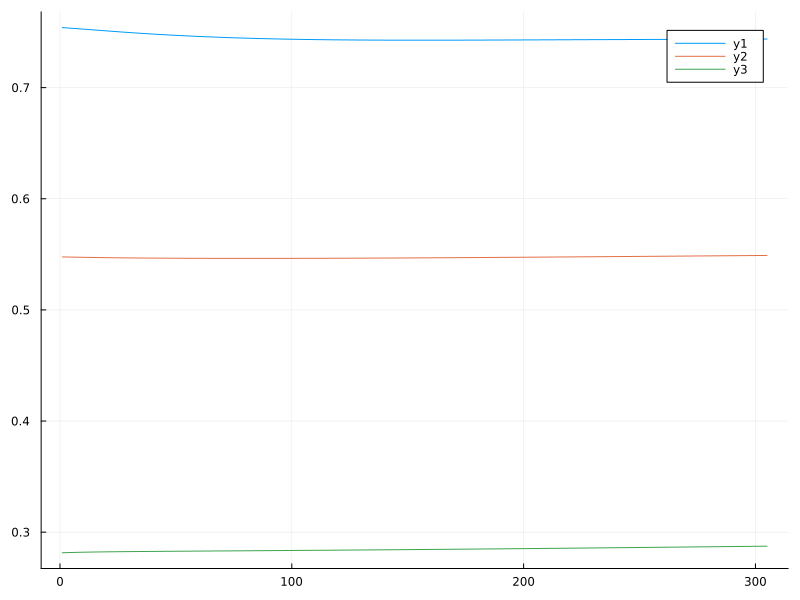

In [39]:
 plot([muy_vector[l][1] for l=1:length(mu_vector)])
plot!([muy_vector[l][2] for l=1:length(mu_vector)])
plot!([muy_vector[l][3] for l=1:length(mu_vector)])

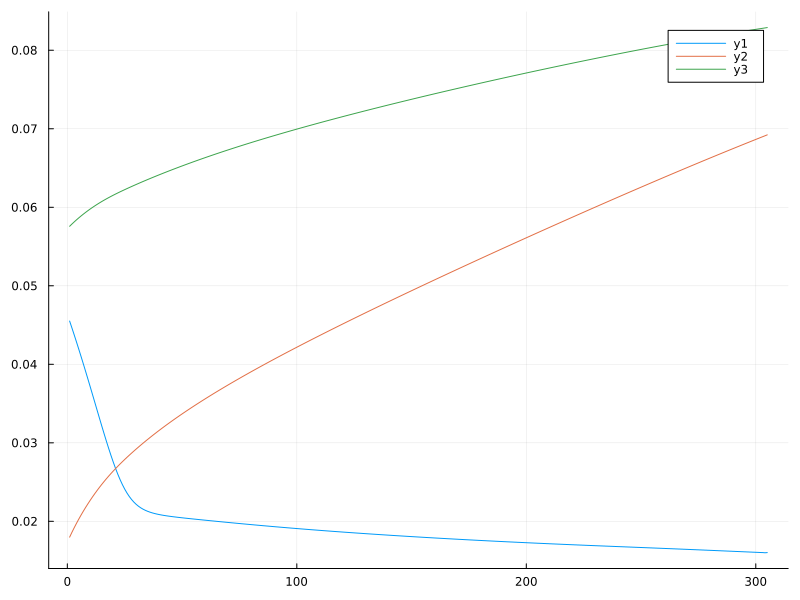

In [40]:
 plot([sigma2_vector[l][1] for l=1:length(sigma2_vector)])
plot!([sigma2_vector[l][2] for l=1:length(sigma2_vector)])
plot!([sigma2_vector[l][3] for l=1:length(sigma2_vector)])

In [39]:
plot(data.shape, fill_z=reshape(integrates.*sum(data.TotalKms), 1, nrow(data)))
savefig("estimated.pdf")